Kawasaki Quantum Summer Camp 2024

# 量子機械学習：解答例


Kifumi Numata, IBM Quantum (Jul 31, 2024)

Google Colab で行う場合は、次のセルの「#」を削除して実行します。

In [ ]:
#!pip install qiskit==1.4.1 qiskit-ibm-runtime==0.35.0 qiskit-aer qiskit[visualization]
#!pip install scikit-learn 

qBraid で行う場合は、右上の「Python 3[Default]」をクリックして「Python 3[QDC24]」を選択し、次のセルの「#」を削除して実行したあと、上部の「Kernel」→「Restart Kernel...」からカーネルをリスタートしてください。

In [ ]:
#!pip install qiskit==1.4.1 qiskit-ibm-runtime==0.35.0
#!pip install scikit-learn 

In [2]:
import numpy as np

# 描画のため
import matplotlib.pyplot as plt

# Scikit-learnのインポート(Python用の機械学習ライブラリー)
from sklearn import datasets
from sklearn.model_selection import train_test_split # データ分割
from sklearn.svm import SVC # SVM Classification(SVM分類)
from sklearn.decomposition import PCA # Principal component analysis(主成分分析)
from sklearn.preprocessing import StandardScaler, MinMaxScaler # 標準化、正規化のスケール変換

# Qiskitのインポート
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import ZZFeatureMap
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2
from qiskit.circuit.library import UnitaryOverlap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

## データを用意

ここでは，手書き数字画像のデータセット(MNISTデータセット)から0と1のサブセットを扱います。

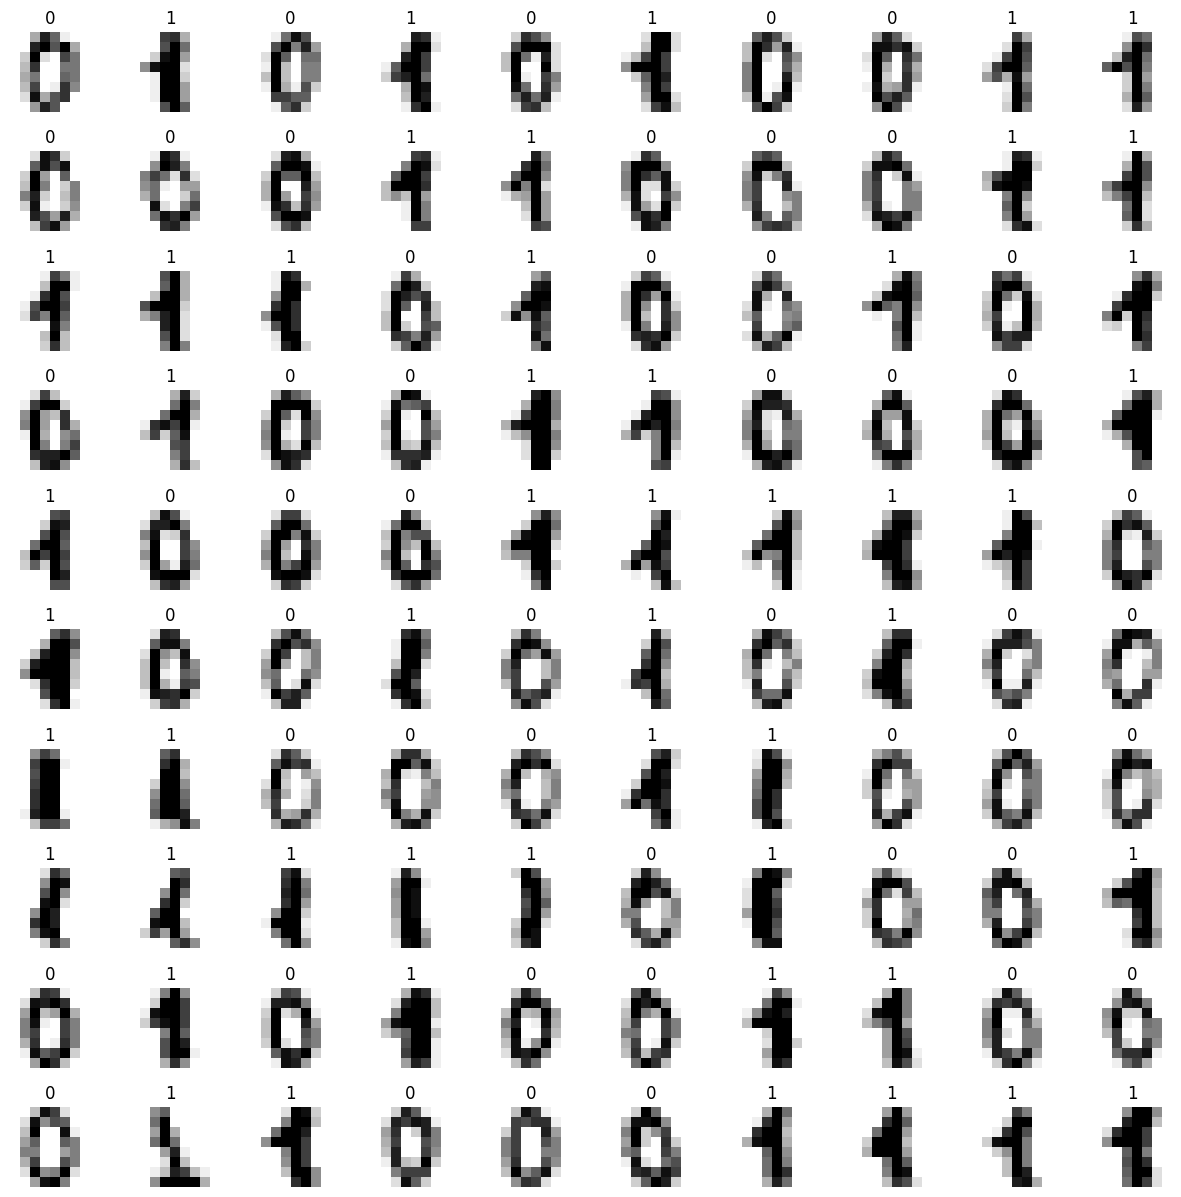

In [3]:
# 数字データセットから2クラスのデータ(0と1)を読み込み
digits = datasets.load_digits(n_class=2)   

# 読み込んだ画像の最初の100枚をプロット
fig, axes = plt.subplots(10, 10, figsize=(15, 15), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.5, wspace=0.5))
for i, ax in enumerate(axes.flat):
    ax.set_axis_off()
    ax.imshow(digits.images[i], cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(digits.target[i])

In [4]:
print(digits.images[0])

[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


このデータセットには、合計360個のデータが含まれています。各データポイントは、8×8の数字の画像で、配列になっていて、各要素は0（白）から16（黒）までの整数です。古典的な分類アルゴリズムの際と同様に、データセットを学習用（25個）とテスト用（10個）のサンプルに分割し、正規化する必要があります。このデータセットを量子分類アルゴリズムに用いるために、範囲を-1から1の間にスケーリングし、次元を使用する量子ビット数（今回は4）に縮小します。

In [5]:
# データセットの分割
sample_train, sample_test, labels_train, labels_test = train_test_split(
     digits.data, digits.target, test_size=0.4, random_state=22)

# 次元削除
n_dim = 4
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# 正規化
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# スケーリング
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# 学習用25個とテスト用10個を選択
train_size = 25
sample_train = sample_train[:train_size]
labels_train = labels_train[:train_size]

test_size = 10
sample_test = sample_test[:test_size]
labels_test = labels_test[:test_size]

In [6]:
# 一つ目のデータをそれぞれ表示
print(sample_train[0], labels_train[0])
print(sample_test[0], labels_test[0])

[-0.84125996  0.08883315 -0.41289909 -0.08403989] 0
[0.41456664 0.7486731  0.74168091 0.32496914] 1


In [7]:
# 学習用データのラベルを表示
print(labels_train)

[0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1]


## データ符号化(エンコード)

この古典データを、量子特徴量マップ(ZZFeatureMap)を用いて量子状態空間にエンコードしていきます。

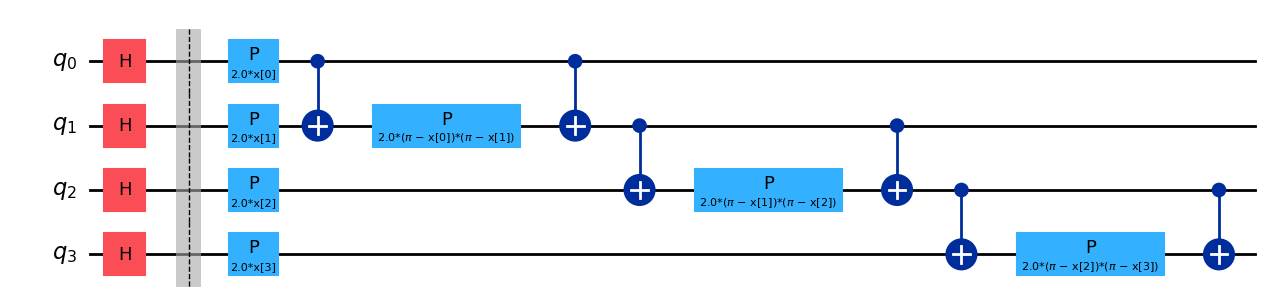

In [8]:
# 4特徴量、深さ(繰り返し数)1のZZFeatureMap
zz_map = ZZFeatureMap(feature_dimension=4, reps=1, entanglement='linear', insert_barriers=True)
zz_map.decompose().draw('mpl')

### 量子カーネルの計算

ZZFeatureMapを使って、学習データの0個目と1個目のデータについて、量子カーネルを計算する量子回路を作成し、実際に計算してみます。この値は、二つの量子状態のFidelity(忠実度)ともいいます。

In [9]:
print(sample_train[0])
print(sample_train[1])

[-0.84125996  0.08883315 -0.41289909 -0.08403989]
[-0.63560347  0.29571254 -0.49227085  0.39130638]


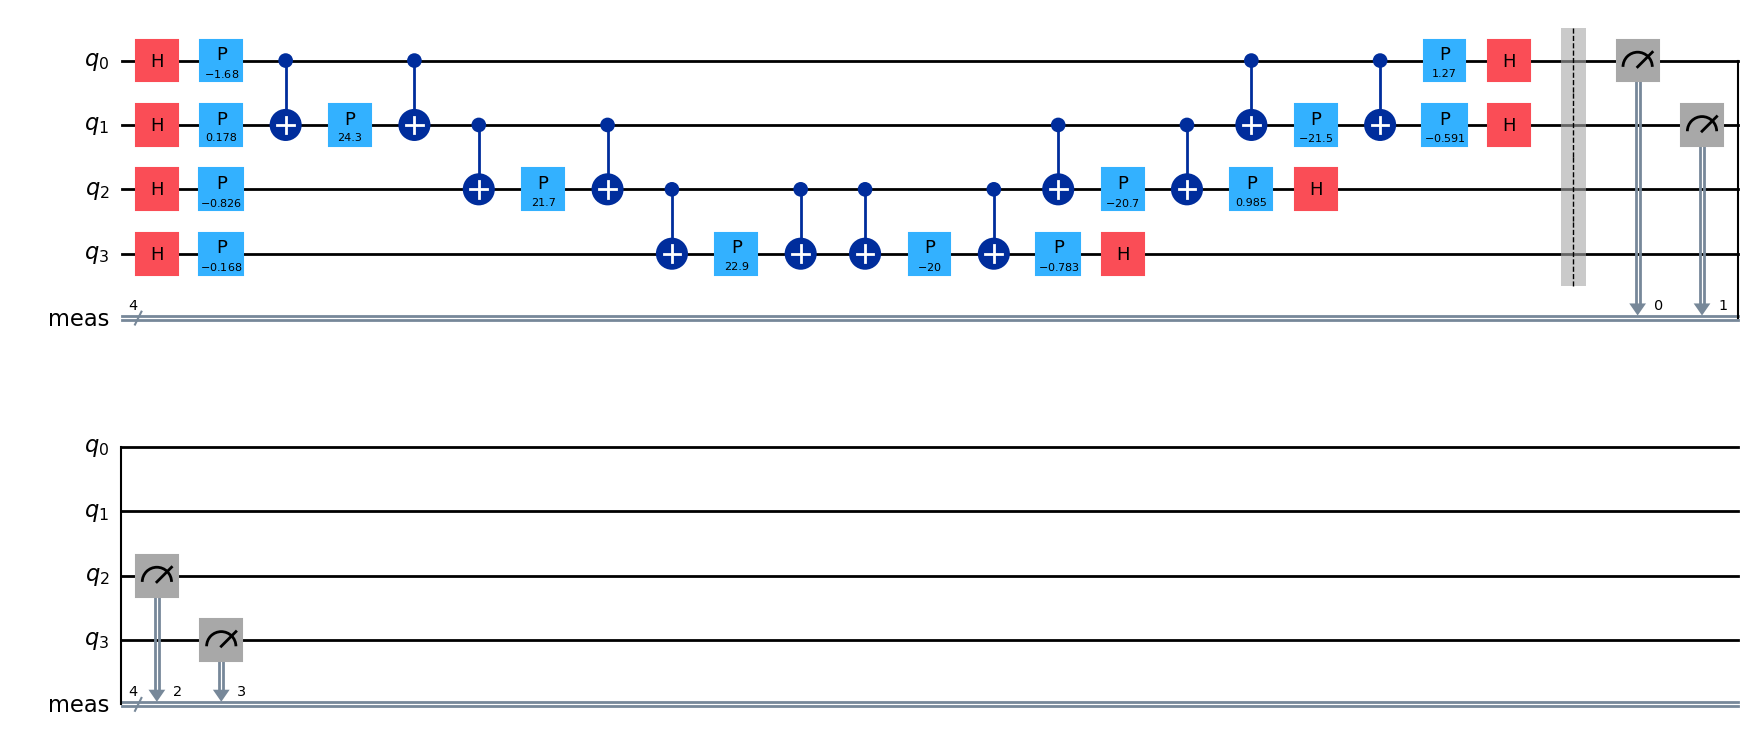

In [10]:
zz_map = ZZFeatureMap(feature_dimension=4, reps=1, entanglement='linear')
qc_1 =zz_map.assign_parameters(sample_train[0])
qc_2 =zz_map.assign_parameters(sample_train[1])
fidelity_circuit = qc_1.copy()
fidelity_circuit.append(qc_2.inverse().decompose(), range(fidelity_circuit.num_qubits))
fidelity_circuit.measure_all()
fidelity_circuit.decompose().draw('mpl')

各回転ゲートのパラメーター値は少し読みにくいですが、回路が対称になっていることが分かると思います。左半分は学習データsample_train[0]が、右半分は学習データsample_train[1]がコード化されています。

例として、上記の量子カーネルを測定し、ゼロ状態のカウント数の割合として、カーネル行列の要素（訓練データの0個目と1個目のデータについて）を計算します。

In [11]:
# シミュレーターで実験
backend = AerSimulator()
# 回路を最適化
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_qc = pm.run(fidelity_circuit)

In [12]:
nshots = 1024
# Samplerで実行
sampler = SamplerV2(backend)
job = sampler.run([isa_qc], shots=nshots)
result = job.result()

#  測定された回数を表示
counts = result[0].data.meas.get_counts()
print(counts)

{'1001': 167, '1111': 560, '1110': 19, '1101': 37, '0111': 144, '0001': 42, '0110': 13, '1000': 5, '0011': 8, '1011': 6, '1100': 11, '0100': 3, '1010': 5, '0101': 2, '0010': 1, '0000': 1}


In [13]:
counts.get('0000')/sum(counts.values())

0.0009765625

### 量子カーネル計算

このプロセスを，学習データサンプルのペアごとに繰り返して学習カーネル行列を埋めていきます。
先ほどど同じ `ZZFeatureMap` を用いて量子回路を作り、また、今回は、 ``UnitaryOverlap`` を使ってカーネル行列の要素となるfidelityを計算します。

In [14]:
zz_map = ZZFeatureMap(feature_dimension=4, reps=1, entanglement='linear')
fidelity = UnitaryOverlap(zz_map, zz_map)
fidelity.measure_all()

回路の形状を見てみましょう。

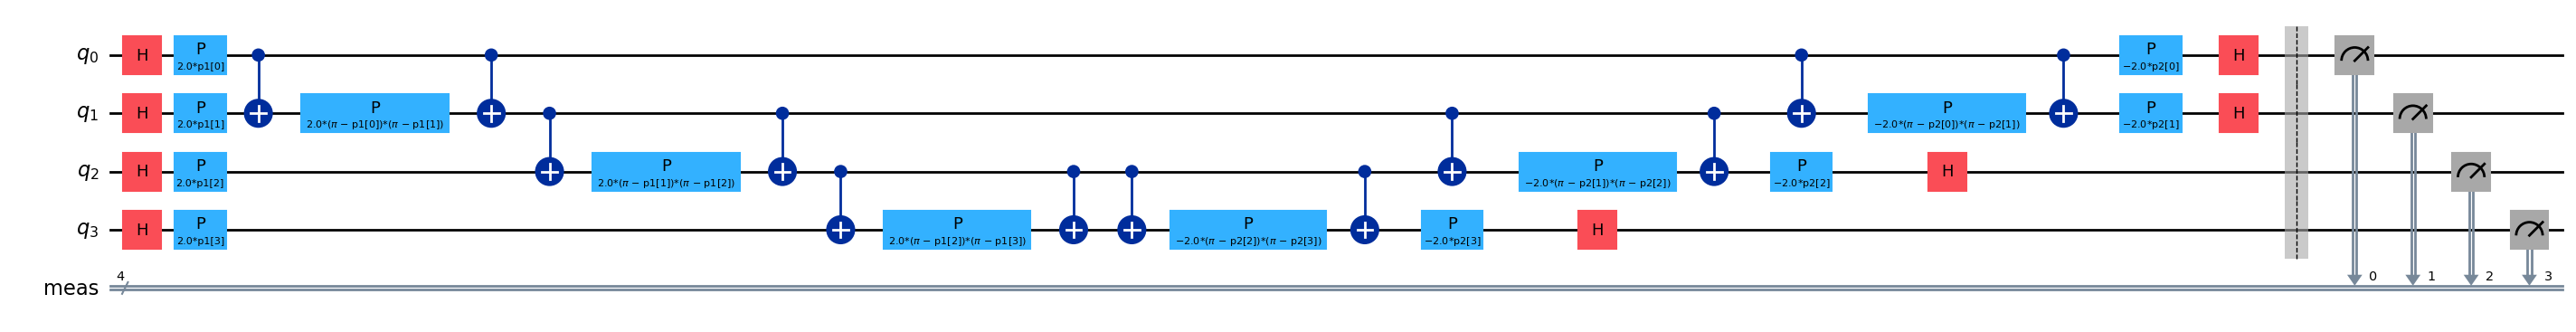

In [15]:
fidelity.decompose().draw('mpl', idle_wires=False, fold=-1)

### 計算すべきカーネル行列の要素数

データ数が$n$のとき、カーネル行列は、$n \times n$ の形をしていて、要素数は、$n^2$個です。しかし、カーネル行列は、[対称行列](https://ja.wikipedia.org/wiki/%E5%AF%BE%E7%A7%B0%E8%A1%8C%E5%88%97)であるため、計算する要素数を少なくすることができます。また、対角要素がみな1であることがわかっているため、この計算も省けます。（参照：[対角行列](https://ja.wikipedia.org/wiki/%E5%AF%BE%E8%A7%92%E8%A1%8C%E5%88%97)）よってデータ数が$n$のとき、計算しなければならないカーネル行列の要素数は、
$$ (n-1) + (n-2) + ... + 2 + 1 $$
個です。
この数の分だけ、量子カーネルのパラメーター化回路を作成し、計算する必要があります。

今回は、データ数が$n=25$なので、カーネル行列には$25 \times 25=625$個の要素がありますが、計算に必要な要素数は、以下より$300$個であることがわかります。

In [16]:
n = 25
circuit_num = np.arange(0,n).sum() #0~24までの数列の和
print(circuit_num)

300


### 量子カーネル回路にデータをエンコードする関数
次に、量子カーネル回路にデータをエンコードするデータのリスト `data_append_train` を作成します。ここで、`n`はデータ数、`x1`、`x2`は入力するデータのリストです。

In [17]:
def data_append_train(n, x1, x2):
    para_data = []
    #
    for i in range(n):
        for j in range(n):
            if i<j:
                para_data.append(list(x1[i])+list(x2[j]))
    #   
    return para_data

学習データとして、手書き数字画像のデータセット(MNISTデータセット)から作成した `sample_train` を使用して、パラメーターリスト`parameter_train`を作ります。

In [18]:
parameter_train = data_append_train(n, sample_train, sample_train)

### 量子カーネル回路をSamplerで計算

backendで実行可能な形にトランスパイルされた`isa_circuit`とパラメーターリスト`parameter_train`を引数 PUB (primitive unified blocs)として入力することで、パラメーターリストの数、つまり300回分の`isa_circuit`を一度にSamplerで実行します。

In [19]:
# シミュレーターで実験
backend = AerSimulator()
# 回路を最適化
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_qc = pm.run(fidelity)

# Samplerで実行
sampler = SamplerV2(backend)
pub = (isa_qc, parameter_train) #samplerに入れる引数
job = sampler.run([pub], shots=nshots)
quantum_kernel = job.result()

実行結果からカーネル行列`K`を作ります。まず`kernel_list`のリストに300個のカウント結果を入れます。すべて要素がゼロの $n \times n$ のカーネル行列`K` を作り、順に結果を入れていきます。

In [20]:
def kernel(quantum_kernel, circuit_num, n):
    kernel_list = []
    for i in range(circuit_num):
        kernel_list += [quantum_kernel[0].data.meas.get_counts(i).get('0000',0)/nshots]

    K = np.zeros((n,n))
    count = 0
    for i in range(n):
        for j in range(n):
            if j<i:
                K[i,j] = K[j,i]
            else:
                if j==i:
                    K[i,j] = 1
                else:
                    K[i,j] = kernel_list[count]
                    count+=1
    return K

In [21]:
K = kernel(quantum_kernel, circuit_num, n)

完成したカーネル行列をプロットしてみましょう。

Text(0.5, 1.0, 'training kernel matrix')

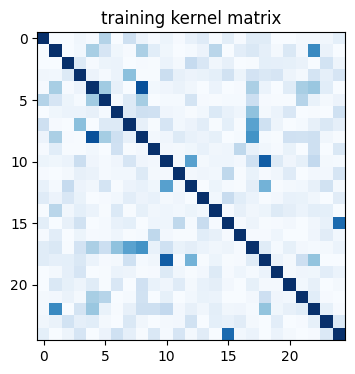

In [22]:
# カーネル行列の表示
fig, axs = plt.subplots(1, 1, figsize=(8, 4))
axs.imshow(np.asmatrix(K),
              interpolation='nearest', origin='upper', cmap='Blues')
axs.set_title("training kernel matrix")

## 学習
古典SVM分類器`scikit-learn`の`SVC`アルゴリズムを使って学習し、テストデータで学習率を見てみます。

In [23]:
svc_m = SVC(kernel='precomputed') 
# SVM で学習します
svc_m.fit(K, labels_train)

# 学習データの学習率を見てみます
y_predict = svc_m.predict(K)
print('accuracy (sim):', sum(y_predict == labels_train)/len(labels_train))

accuracy (sim): 1.0


In [24]:
print(labels_train, y_predict)

[0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1] [0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1]


100%の確率で学習されました。つまり、正確な量子分類器を作成することに成功しました。

### 学習データとテストデータとのカーネル行列の作成

テスト用のデータを使って、上で作った量子分類機でラベル(0または1)を予測してみましょう。そのためには、学習データとテストデータとのカーネル行列を作成する必要があります。この行列は、テストデータが10個、学習データが25個なので、$25 \times 10=250$個のカーネル回路の計算が必要になります。

In [25]:
n1 = 10 #テストデータの数
n2 = 25 #学習データの数
circuit_num_test = n1 * n2
print(circuit_num_test)

250


量子カーネル回路にデータをエンコードする関数`data_append_test`は、以下のように作られ、ここで`x1`は テストデータのリスト、`x2`は学習データのリストです。

In [26]:
def data_append_test(n1, n2, x1, x2):
    data_append_test = []
    for i in range(n1):
        for j in range(n2):
            data_append_test.append(list(x1[i])+list(x2[j]))
    return data_append_test

テストデータ`sample_test`と学習データ`sample_train`を使用して、パラメーターリスト`parameter_test`を作り、samplerでカーネル計算回路を計算します。

In [27]:
parameter_test = data_append_test(n1, n2, sample_test, sample_train)

backendで実行可能な形にトランスパイルされた`isa_qc`とパラメーターリスト`parameter_test`を引数 PUB (primitive unified blocs)として入力することで、パラメーターリストの数、つまり250回分の`isa_qc`を一度にSamplerで実行します。

In [28]:
# シミュレーターで実験
backend = AerSimulator()
# 回路を最適化
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_qc = pm.run(fidelity)

# Samplerで実行
sampler = SamplerV2(backend)
parameter_list_test = data_append_test(n1, n2, sample_test, sample_train)
pub = (isa_qc, parameter_test) #samplerに入れる引数
job = sampler.run([pub], shots=nshots)
quantum_kernel_test = job.result()

実行結果からカーネル行列`K_test`を作ります。まず`kernel_list`のリストに250個のカウント結果を入れます。すべて要素がゼロのカーネル行列`K_test`を作り、順に結果を入れていきます。

In [31]:
def kernel_test(quantum_kernel_test, circuit_num_test, n1, n2):
    kernel_list = []
    for i in range(circuit_num_test):
        kernel_list += [quantum_kernel_test[0].data.meas.get_counts(i).get('0000',0)/nshots]

    K_test = np.zeros((n1, n2))
    count = 0
    for i in range(n1):
        for j in range(n2):
            K_test [i,j] = kernel_list[count]
            count+=1
    return K_test

Text(0.5, 1.0, 'testing kernel matrix')

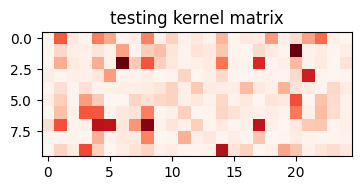

In [32]:
K_test = kernel_test(quantum_kernel_test, circuit_num_test, n1, n2)

# カーネル行列の表示
fig, axs = plt.subplots(1, 1, figsize=(4, 2))
axs.imshow(np.asmatrix(K_test),
              interpolation='nearest', origin='upper', cmap='Reds')
axs.set_title("testing kernel matrix")

In [33]:
#学習データとテストデータとのカーネル行列を使ってテストデータのラベルを予測
label_predict = svc_m.predict(K_test)
print(label_predict, labels_test)

[0 1 0 1 1 1 0 0 1 0] [1 1 0 1 1 1 0 0 1 0]


In [34]:
#精度を見てみます
print('accuracy (sim):', sum(label_predict == labels_test)/len(labels_test))

accuracy (sim): 0.9


## 実機で実行するには

実機で実行するには、バックエンドに実デバイスを指定し、実機に合わせてトランスパイルして、実行するだけです。ただし、各実験に5分、4分の合計9分かかってしまうため、皆さんが実行するのは、またの機会にしたいと思います。以下は、ibm_kyotoで実験した結果です。よく判別できています。

In [35]:
# local環境で初めて実行する場合は、認証情報をディスクに保存します：
# QiskitRuntimeService.save_account(channel='ibm_quantum', instance='ibm-q/open/main', token='<IBM Quantum API key>')
service = QiskitRuntimeService()

In [ ]:
#一番空いているバックエンドを自動的に選択することもできます
backend = service.least_busy(operational=True)
print("最も空いているバックエンドは: ", backend)

In [37]:
# 以下でデバイスを指定できます。
backend = service.backend('ibm_brisbane')

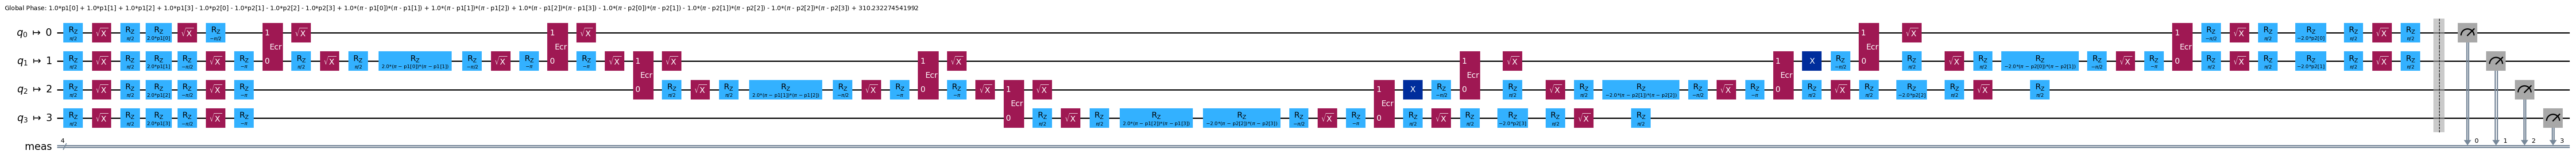

In [38]:
# 回路を実機で実行可能な基底ゲートにトランスパイルします
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(fidelity)
isa_circuit.draw("mpl", idle_wires=False, fold=-1)

### 学習データと学習データとのカーネル行列の作成(実機)

In [39]:
nshots = 1024
sampler = SamplerV2(backend)
pub = (isa_circuit, parameter_train)
#job = sampler.run([pub], shots=nshots) #ここの#を外すと実行できます。
job.job_id() # job idの確認

'd049kp4l3fjs7395fdfg'

In [41]:
job = service.job('d049kp4l3fjs7395fdfg') 
job.status() # ジョブの実行状態を確認します

'DONE'

In [42]:
#### 上のセルがDONEになってから実行します ####
quantum_kernel = job.result()

Text(0.5, 1.0, 'training kernel matrix')

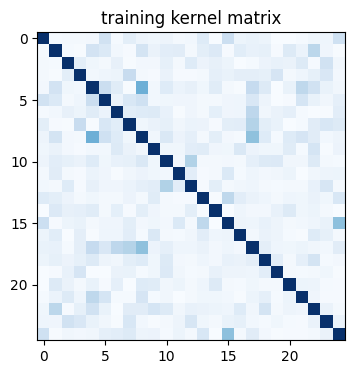

In [43]:
K = kernel(quantum_kernel, circuit_num, n)
# カーネル行列の表示
fig, axs = plt.subplots(1, 1, figsize=(8, 4))
axs.imshow(np.asmatrix(K),
              interpolation='nearest', origin='upper', cmap='Blues')
axs.set_title("training kernel matrix")

In [44]:
svc = SVC(kernel='precomputed') 
# SVM で学習します
svc.fit(K, labels_train)

# 学習データの学習率を見てみます
y_predict = svc.predict(K)
print('accuracy (sim):', sum(y_predict == labels_train)/len(labels_train))

accuracy (sim): 1.0


### 学習データとテストデータとのカーネル行列の作成(実機)

In [45]:
sampler = SamplerV2(backend)
pub = (isa_circuit, parameter_test)
#job = sampler.run([pub], shots=nshots) #を外すと実行できます
job.job_id() # job idの確認

'd049m8mn74ec73b56ejg'

In [46]:
job = service.job('d049m8mn74ec73b56ejg') 
job.status() # ジョブの実行状態を確認します

'DONE'

In [47]:
#### 上のセルがDONEになってから実行します ####
quantum_kernel_test = job.result()

Text(0.5, 1.0, 'testing kernel matrix')

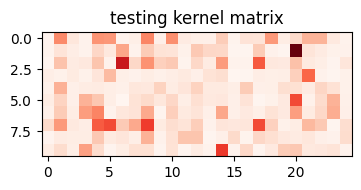

In [48]:
K_test = kernel_test(quantum_kernel_test, circuit_num_test, n1, n2)

# カーネル行列の表示
fig, axs = plt.subplots(1, 1, figsize=(4, 2))
axs.imshow(np.asmatrix(K_test),
              interpolation='nearest', origin='upper', cmap='Reds')
axs.set_title("testing kernel matrix")

In [49]:
svc = SVC(kernel='precomputed')
# train SVM
svc.fit(K, labels_train)

# score SVM on training data
y_predict = svc.predict(K)
print('accuracy (sim):', sum(y_predict == labels_train)/len(labels_train))

accuracy (sim): 1.0


# 洋服画像データの分類


ここで扱うデータは，MNISTデータセットの亜種である[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist/blob/master/README.ja.md)という洋服画像データセットのサブセットです。

<center><div><img src="https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/refs/heads/master/doc/img/fashion-mnist-sprite.png" width="640" /></div></center>

Image source:[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist/blob/master/README.ja.md)

以下のラベルの画像について分類します。

- label 2: プルオーバー
- label 3: ドレス

まずデータセットを読み込んで，クラスごとに1枚ずつ画像を表示してみます。

**注意**：Google Colab で行う場合は、左側のフォルダーアイコンをクリックし、`fashion.npz`をセッションストレージにアップロードし、ファイルを右クリックして、ファイルのパスをコピーし、以下のセルの`DATA_PATH = 'パス名'`にセットします。

![image.jpg](https://raw.githubusercontent.com/quantum-tokyo/kawasaki-quantum-camp/refs/heads/main/day2/qml/upload_file.jpg)

それ以外の環境の方は、このnotebookと同じフォルダーに`fashion.npz`を保存します。

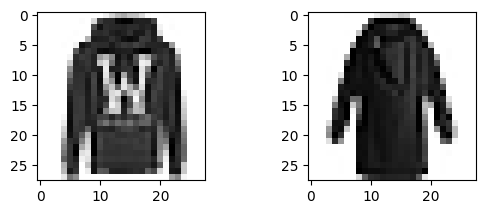

In [50]:
# データのロード
DATA_PATH = 'fashion.npz' # Google colabの場合はここにパスを上書きしてください。
data = np.load(DATA_PATH)

sample_train = data['sample_train']
labels_train = data['labels_train']
sample_test = data['sample_test']

# データセットの分割
sample_train, sample_test, labels_train, labels_test = train_test_split(
    sample_train, labels_train, test_size=0.2, random_state=42)

# データの表示
fig = plt.figure()
LABELS = [2,3]
num_labels = len(LABELS)
for i in range(num_labels):
    ax = fig.add_subplot(2, num_labels, i+1)
    img = sample_train[labels_train==LABELS[i]][0].reshape((28, 28))
    ax.imshow(img, cmap="Greys")

次に，以下のデータセットの前処理をします

- 主成分分析(PCA)による次元圧縮
- 正規化
- スケーリング
- 学習用（80個）とテスト用（10個）のサンプルを選択


In [51]:
# 次元削除
N_DIM = 4
pca = PCA(n_components=N_DIM).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# 正規化
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# スケーリング
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# 選択
train_size = 80
sample_train = sample_train[:train_size]
labels_train = labels_train[:train_size]

test_size = 10
sample_test = sample_test[:test_size]
labels_test = labels_test[:test_size]

In [52]:
# 一つ目のデータをそれぞれ表示
print(sample_train[0], labels_train[0])
print(sample_test[0], labels_test[0])

[ 0.6363233   0.2027854  -0.2019908   0.61951842] 2
[-0.21931836  1.         -0.08839206  0.0861703 ] 3


## 演習

この洋服画像データについて、特徴量マップ(ZZFeatureMap)を使ってカーネル行列を計算し、古典のSVMを使って学習してみます。学習率を確認してみましょう。「#コードを入れてください」にコードを記入して、コードを完成させてください。


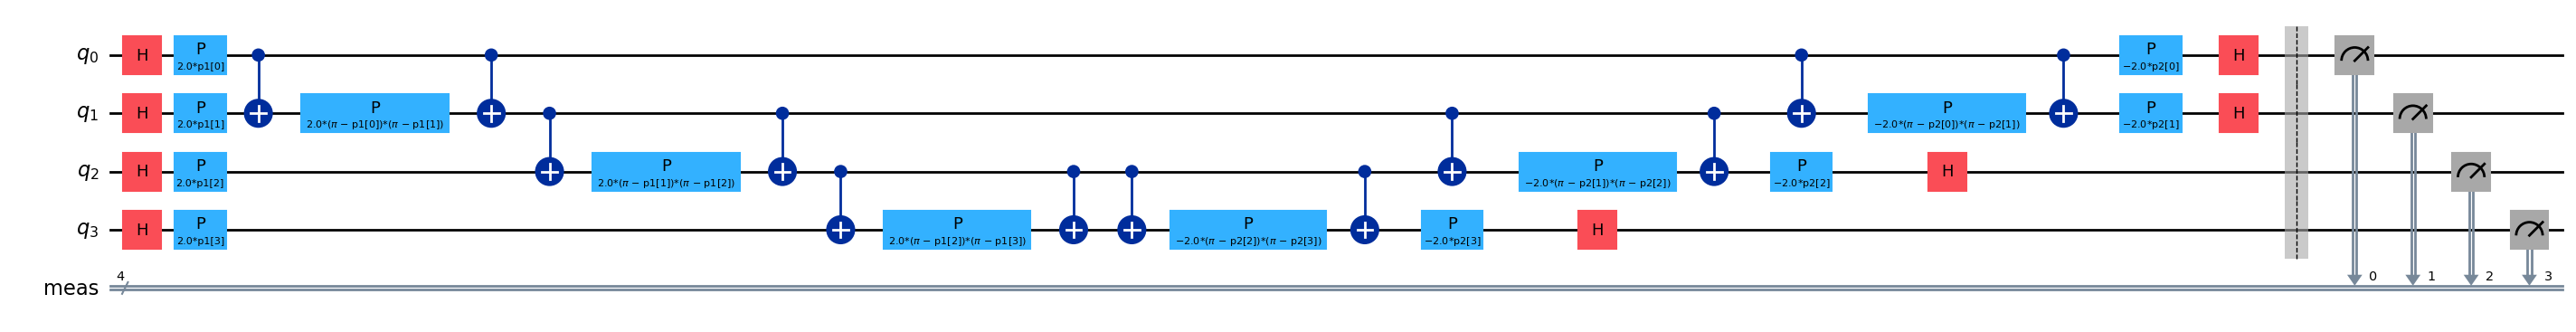

In [53]:
zz_map = ZZFeatureMap(feature_dimension=4, reps=1, entanglement='linear') #コードを入れてください -1
fidelity = UnitaryOverlap(zz_map, zz_map) #コードを入れてください -2
fidelity.measure_all()
fidelity.decompose().draw('mpl', idle_wires=False, fold=-1)

まず、学習データ同士のカーネル行列を計算します。

In [54]:
# 計算すべきカーネル行列の要素数の計算
n = train_size 
circuit_num = np.arange(0,n).sum() #0~n-1までの数列の和
print(circuit_num)

3160


上で作った`data_append_train`関数を使って、学習データ`sample_train`をSamplerに入れるパラメーター`parameter_train`として準備します。

In [55]:
# 学習データをパラメーターにします
parameter_train = data_append_train(n, sample_train, sample_train)

backendで実行可能な形にトランスパイルされた`isa_qc`とパラメーターリスト`parameter_train`を引数 PUB (primitive unified blocs)として入力することで、パラメーターリストの数、つまり3160回分の`isa_qc`を一度にSamplerで実行します。

In [56]:
# シミュレーターで実験
backend = AerSimulator()
# 回路を最適化
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_qc = pm.run(fidelity)

# Samplerで実行
sampler = SamplerV2(backend)
pub = (isa_qc, parameter_train)#コードを入れてください -3
job = sampler.run([pub], shots=nshots)
quantum_kernel = job.result()

Text(0.5, 1.0, 'training kernel matrix')

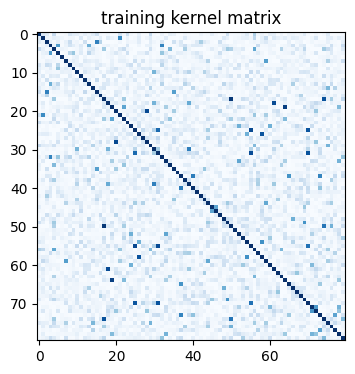

In [57]:
K = kernel(quantum_kernel, circuit_num, n)
# カーネル行列の表示
fig, axs = plt.subplots(1, 1, figsize=(8, 4))
axs.imshow(np.asmatrix(K),
              interpolation='nearest', origin='upper', cmap='Blues')
axs.set_title("training kernel matrix")

古典SVM分類器`scikit-learn`の`SVC`アルゴリズムを使って学習し、テストデータで学習率を見てみます。

In [58]:
svc_f = SVC(kernel='precomputed') 
# SVM で学習します
svc_f.fit(K, labels_train)

# 学習データの学習率を見てみます
y_predict = svc_f.predict(K)
print('accuracy (sim):', sum(y_predict == labels_train)/len(labels_train))

accuracy (sim): 0.975


ここまでで、量子分類機の作成が完了しました。次に、テストデータを使って、作った量子分類機の精度を確認してみます。

In [59]:
# 計算すべきカーネル行列の要素数の計算
n1 = test_size #テストデータの数
n2 = train_size #学習データの数
circuit_num_test = n1 * n2
print(circuit_num_test)

800


上で作った`data_append_test`関数を使って、テストデータ`sample_test`と学習データ`sample_train`とをSamplerに入れるパラメーター`parameter_test`として準備します。

In [60]:
# テストデータをパラメーターにします
parameter_test = data_append_test(n1, n2, sample_test, sample_train)

backendで実行可能な形にトランスパイルされた`isa_qc`とパラメーターリスト`parameter_test`を引数 PUB (primitive unified blocs)として入力することで、パラメーターリストの数、つまり800回分の`isa_qc`を一度にSamplerで実行します。

In [61]:
# シミュレーターで実験
backend = AerSimulator()
# 回路を最適化
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_qc = pm.run(fidelity)

# Samplerで実行
sampler = SamplerV2(backend)
pub = (isa_qc, parameter_test)#(コードを入れてください -4)
job = sampler.run([pub], shots=nshots)
quantum_kernel_test = job.result()

Text(0.5, 1.0, 'testing kernel matrix')

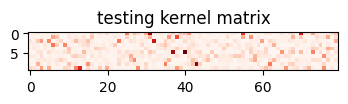

In [62]:
K_test = kernel_test(quantum_kernel_test, circuit_num_test, n1, n2)

# カーネル行列の表示
fig, axs = plt.subplots(1, 1, figsize=(4, 2))
axs.imshow(np.asmatrix(K_test),
              interpolation='nearest', origin='upper', cmap='Reds')
axs.set_title("testing kernel matrix")

作った量子分類器`svc_f`と`K_test`をテストデータの精度を確認します。

In [63]:
y_predict = svc_f.predict(K_test)
print(y_predict, labels_test)

[3 3 3 3 2 2 3 3 2 3] [3 3 3 3 2 2 2 2 2 3]


In [64]:
print('accuracy (sim):', sum(y_predict == labels_test)/len(labels_test))

accuracy (sim): 0.8


## 時間の余った方向け

データセットunknown_dataが プルオーバー（ラベル2）、またはドレス（ラベル3）、どちらのデータセットであるかを学習した量子カーネル行列を使って、SVMで判別してください。データunknown_dataは、10個の同じラベルのデータセットを次元削除、正規化、スケーリングしたものです。

In [65]:
unknown_data =[[-0.13116065, -0.06375504, -0.13685728,  0.84755115],
                [-0.37941815, -0.76067967, -0.22019793,  0.17362356],
               [-0.32055824, -0.32319408, -0.36608317,  0.68697767],
               [ 0.31559114, -0.22212598, -0.01367073,  0.26984296],
               [ 0.61950235,  0.11437916, -0.71187256, -0.20481759],
               [ 0.81223033,  0.16992666,  0.0184564,   0.03393165],
               [ 0.84295123,  0.07871908, -0.73484068,  0.05869072],
               [-0.32055824, -0.32319408, -0.36608317,  0.68697767],
               [ 0.31559114, -0.22212598, -0.01367073,  0.26984296],
               [ 0.61950235,  0.11437916, -0.71187256, -0.20481759]]

In [66]:
# 学習データとunknown_dataデータとのカーネル行列(80x10)を計算します
# データをパラメーターにします
parameter_train_test = data_append_test(n1, n2, unknown_data, sample_train)

In [67]:
# シミュレーターで実験
backend = AerSimulator()
# 回路を最適化
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_qc = pm.run(fidelity)

# Samplerで実行
sampler = SamplerV2(backend)
pub = (isa_qc, parameter_train_test)
job = sampler.run([pub], shots=nshots)
quantum_kernel_test = job.result()

Text(0.5, 1.0, 'testing kernel matrix')

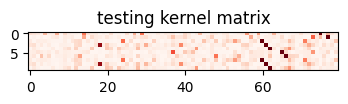

In [68]:
K_test = kernel_test(quantum_kernel_test, circuit_num_test, n1, n2)

# カーネル行列の表示
fig, axs = plt.subplots(1, 1, figsize=(4, 2))
axs.imshow(np.asmatrix(K_test),
              interpolation='nearest', origin='upper', cmap='Reds')
axs.set_title("testing kernel matrix")

In [69]:
# unknown_dataデータのラベルを予測します
y_predict = svc_f.predict(K_test)
print(y_predict)

[2 2 2 2 2 2 2 2 2 2]


In [70]:
import qiskit
qiskit.__version__

'1.4.1'